In [1]:
#TODO treningowy jest dzielony na walidacyjny, moze lepiej dzielić testowy?
from data_helper import get_dataloaders_and_standarscaler_photons
from train_helper import train_autoencoder
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

In [2]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


Device: cpu


In [3]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 100
LOGGING_INTERVAL=4000
path='./DATA/photons.npy'

In [4]:
# #ODCZYTANIE DANYCH Z PLIKU nazwa.txt i utworzenie pliku photons.npy
# f = open('./DATA/nazwa.txt','r')

# photons = []
# for n in range(1000000):
#     l = f.readline()
#     features = l.split()
    
#     if features[0]!='1':
#         continue

#     X = float(features[2])
#     Y = float(features[3])
#     dX = float(features[5])
#     dY = float(features[6])
#     dZ = float(features[7])
#     E = float(features[8])
#     photon = np.asarray([E,X,Y,dX,dY,dZ],dtype=np.float32)
#     photons.append(photon)
    
# photons = np.asarray(photons,dtype=np.float32)
# np.save(path,photons)

In [6]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros(photons.shape,dtype=np.float32)
np.copyto(X,photons)

In [10]:
df_data = pd.DataFrame(X, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane


,X,Y,dX,dY,dZ,E
0,0.42000,1.05666,-5.14814,0.040652,-0.198063,0.979346
1,0.26173,-1.74098,-4.74566,0.052218,-0.303938,0.951260
2,0.39096,1.24705,4.90818,0.019018,0.337769,0.941037
3,0.42000,2.54507,-3.28148,0.098677,-0.127226,0.986953
4,0.42000,1.33431,-4.38559,0.051587,-0.169556,0.984170


In [11]:
print(df_data.shape)

(995401, 6)


In [12]:
from collections import Counter
df_duplicated=df_data.duplicated().to_numpy()
print(Counter(df_duplicated))

#Niektóre dane się powtarzają 



Counter({False: 956910, True: 38491})


In [7]:
#g = sns.pairplot(df_data)

#plt.show()

In [13]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [14]:
#SRAWDZENIE ZBIORU DANYCH
print('Training Set:\n')
for features in train_loader:  
    print('Batch dimensions:', features.size())
    print(features[:4,:6])
    break
    
print('\nValidation Set:')
for features in valid_loader:  
    print('Batch dimensions:', features.size())
    print(features[:4,:6])
    break

print('\nTesting Set:')
for features in test_loader:  
    print('Batch dimensions:', features.size())
    print(features[:4,:6])
    break
    break

Training Set:

Batch dimensions: torch.Size([64, 6])
tensor([[0.3076, 0.3992, 0.4777, 0.4632, 0.4908, 0.9985],
        [0.1816, 0.2606, 0.5154, 0.4105, 0.5055, 0.9918],
        [0.2127, 0.4457, 0.3387, 0.4769, 0.4485, 0.9969],
        [0.1481, 0.3779, 0.4924, 0.4554, 0.4952, 0.9979]])

Validation Set:

Testing Set:
Batch dimensions: torch.Size([64, 6])
tensor([[0.2517, 0.5074, 0.6596, 0.5052, 0.5615, 0.9961],
        [0.0880, 0.6333, 0.3549, 0.5540, 0.4435, 0.9941],
        [0.0486, 0.5373, 0.2460, 0.5166, 0.4020, 0.9903],
        [0.1474, 0.4299, 0.7065, 0.4750, 0.5789, 0.9930]])


In [15]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test

torch.Size([64, 6])


In [16]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(6, 6), 
            nn.ReLU(),
            nn.Linear(6, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
            nn.Linear(5, 6),
            nn.ReLU(),
            nn.Linear(6, 6)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [17]:
model = Autoencoder_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [14]:
log_dict=train_autoencoder(num_epochs=NUM_EPOCHS,model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, device=DEVICE, test_loader=test_loader, logging_interval=LOGGING_INTERVAL)

Epoch: 001/100 | Batch 0000/12442 | Loss: 0.4836
Epoch: 001/100 | Batch 4000/12442 | Loss: 0.0058
Epoch: 001/100 | Batch 8000/12442 | Loss: 0.0047
Epoch: 001/100 | Batch 12000/12442 | Loss: 0.0056
***Epoch: 001/100 | Loss: 0.031
Test***Epoch: 001/100 | Loss: 0.031
Time elapsed: 0.55 min
Epoch: 002/100 | Batch 0000/12442 | Loss: 0.0072
Epoch: 002/100 | Batch 4000/12442 | Loss: 0.0057
Epoch: 002/100 | Batch 8000/12442 | Loss: 0.0047
Epoch: 002/100 | Batch 12000/12442 | Loss: 0.0053
***Epoch: 002/100 | Loss: 0.031
Test***Epoch: 002/100 | Loss: 0.031
Time elapsed: 1.19 min
Epoch: 003/100 | Batch 0000/12442 | Loss: 0.0054
Epoch: 003/100 | Batch 4000/12442 | Loss: 0.0042
Epoch: 003/100 | Batch 8000/12442 | Loss: 0.0001
Epoch: 003/100 | Batch 12000/12442 | Loss: 0.0006
***Epoch: 003/100 | Loss: 0.004
Test***Epoch: 003/100 | Loss: 0.004
Time elapsed: 1.80 min
Epoch: 004/100 | Batch 0000/12442 | Loss: 0.0010
Epoch: 004/100 | Batch 4000/12442 | Loss: 0.0010
Epoch: 004/100 | Batch 8000/12442 | Lo

In [15]:
tmp=df_data.to_numpy(dtype=np.float32)
#print(tmp)
tmp=tmp[:,:]
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
#tmp_label=df_wine.iloc[3,0]
with torch.no_grad():
    result, result_encoded_features=model(tmp.to(device=DEVICE))
result=result.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

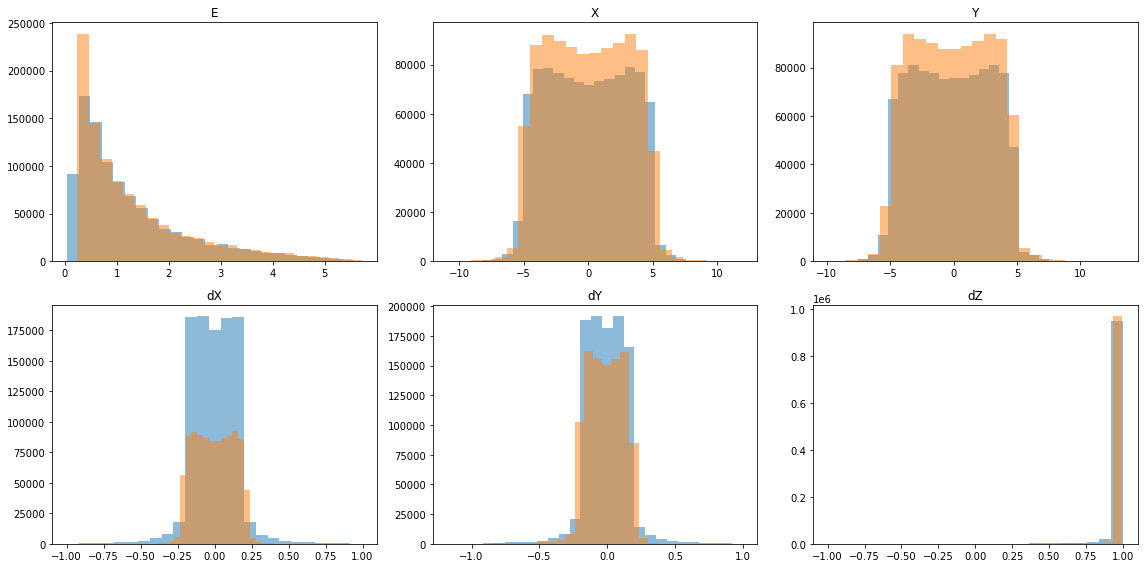

In [16]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
axs[0, 0].hist(orginal[:,0],bins=25, label ='orginal',alpha=0.5)
axs[0, 0].hist(result[:,0],bins=25, label ='encoded', alpha=0.5)
axs[0, 0].set_title('E')
axs[0, 1].hist(orginal[:,1],bins=25, label ='orginal',alpha=0.5)
axs[0, 1].hist(result[:,1],bins=25, label ='encoded', alpha=0.5)
axs[0, 1].set_title('X')
axs[0, 2].hist(orginal[:,2],bins=25, label ='orginal',alpha=0.5)
axs[0, 2].hist(result[:,2],bins=25, label ='encoded', alpha=0.5)
axs[0, 2].set_title('Y')
axs[1, 0].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 0].hist(result[:,3],bins=25, label ='encoded', alpha=0.5)
axs[1, 0].set_title('dX')
axs[1, 1].hist(orginal[:,4],bins=25, label ='orginal',alpha=0.5)
axs[1, 1].hist(result[:,4],bins=25, label ='encoded', alpha=0.5)
axs[1, 1].set_title('dY')
axs[1, 2].hist(orginal[:,5],bins=25, label ='orginal',alpha=0.5)
axs[1, 2].hist(result[:,5],bins=25, label ='encoded', alpha=0.5)
axs[1, 2].set_title('dZ')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

In [17]:
encoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), encoded_df.assign(dataset_name='encoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


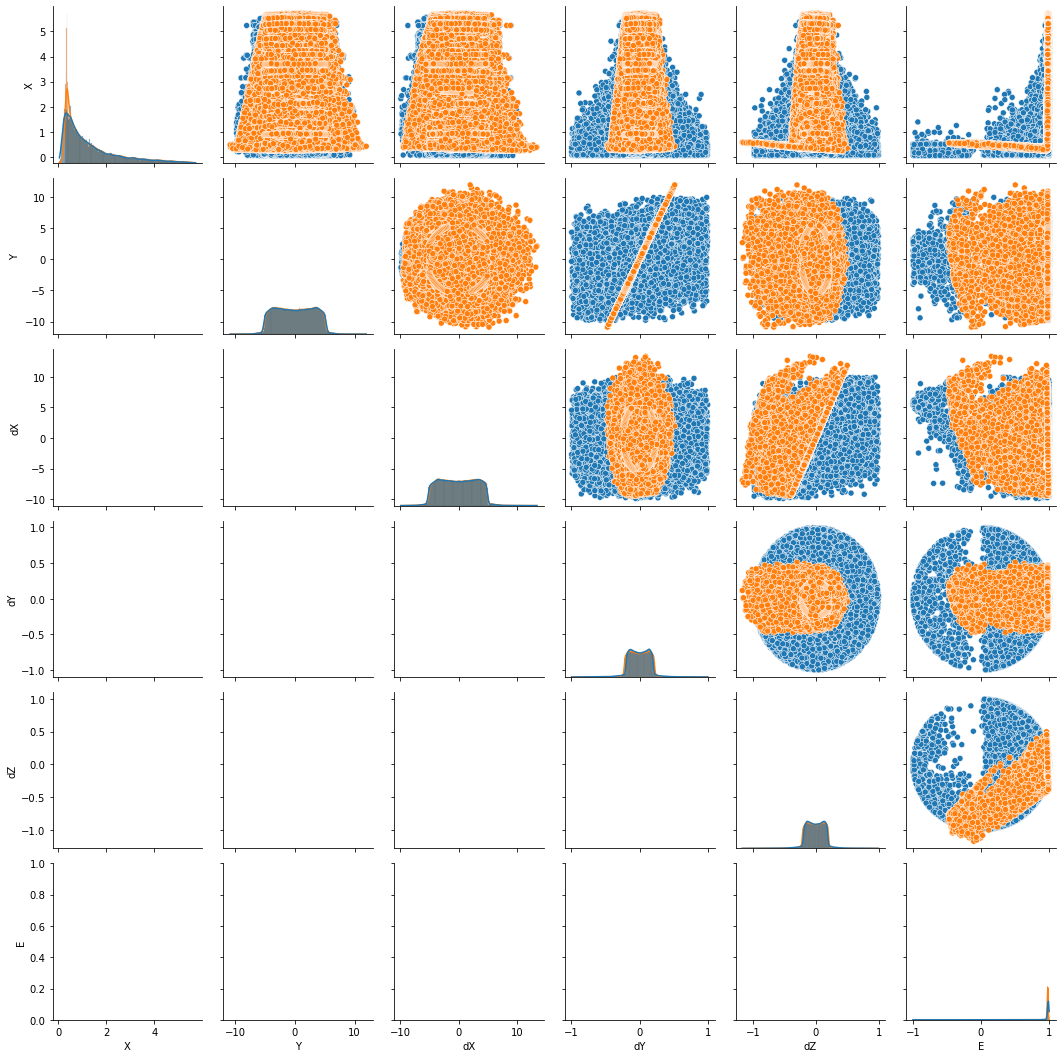

In [18]:
g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [19]:
#trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.0005, random_state=2)) 
print(sample.shape)
print(sample.head())

(996, 7)
                X         Y        dX        dY        dZ         E  \
1174565  1.194423 -1.420929  1.788611 -0.064304  0.072847  0.975571   
1609424  0.708756  1.764658 -2.397477  0.073545 -0.102866  0.980244   
1539655  0.318137  2.089269  2.179402  0.086304  0.090523  0.973486   
1506954  1.213444  2.047743 -0.750658  0.085876 -0.035271  0.978797   
1855494  2.011367  3.755464 -3.621594  0.160826 -0.158969  0.983773   

        dataset_name  
1174565      encoded  
1609424      encoded  
1539655      encoded  
1506954      encoded  
1855494      encoded  


In [20]:
# g = sns.PairGrid(sample, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

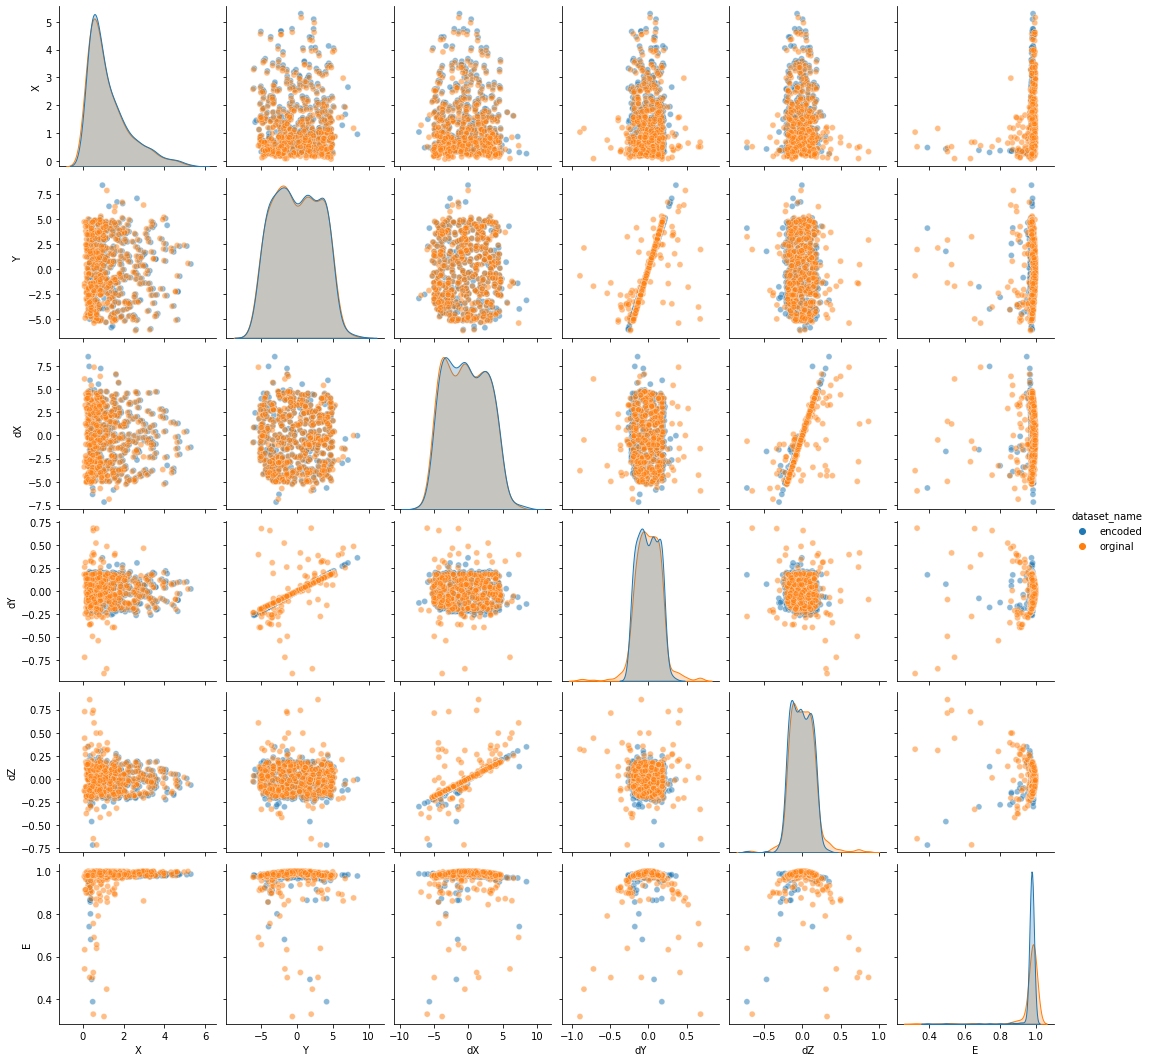

In [21]:
sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [22]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
with torch.no_grad():
    result_2, result_encoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [23]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [24]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.061480,0.76066,-2.51647,0.029714,-0.098330,0.994710
1,2.139241,0.74091,-2.45155,0.030639,-0.109008,0.982582


In [25]:
encoded_features=[]
for index, features in enumerate(train_loader):
    with torch.no_grad():
        recon, tmp_encoded_features=model(features.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

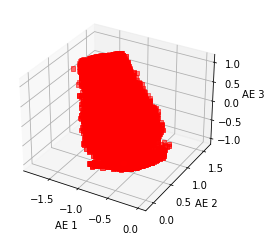

In [26]:
#PRZESTRZEŃ UKRYTA AUTOENCODERA
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('AE 1')
ax.set_ylabel('AE 2')
ax.set_zlabel('AE 3')

plt.show()

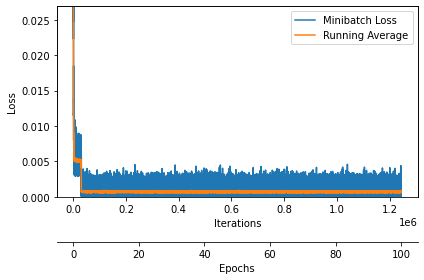

In [27]:
plot_training_loss(log_dict['train_loss_per_batch'],NUM_EPOCHS)

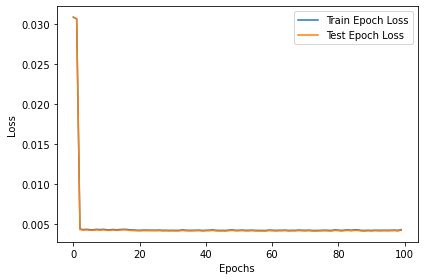

In [28]:
plt.plot(range(len(log_dict['train_loss_per_epoch'])), (log_dict['train_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_loss_per_epoch'])), (log_dict['test_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()